# DSCI 100 Project

In [14]:
library(tidyverse)
library(repr)
library(tidymodels)
library(rvest)
library(janitor)
options(repr.matrix.max.rows = 6)

# Introduction

## Background Information

As digital platforms continue to expand their impact to connect people with similar interests and characteristics, it becomes important for tailored information to reach those in need. In this project, I explore the relationship between unique features of MineCraft players and their subscription to gaming-related newspapers. Results of this investigation will be valuable for organizations looking to spread game-related content, since it will identify their core target audience and maximize the influence of their information. 

## Question

Can subscription to game-related newspaper be predicted by gender, hour of play, and experience in the players dataset, specifically for players in the age range 15 to 25? 

## Data Description

To answer this question we will analyze a dataset of MineCraft player data. The data was collected by the Department of Computer Science at UBC, led by Frank Wood. Each row in the data set contains information of a unique player, with 196 observations present. 

There are 7 columns in the dataset:

- `Experience` - The skill tier
- `subscribe` - Subscription to a gaming-related newplayer
- `hashedEmail` - Email address converted to chr
- `played_hours` - The total gaming time
- `name` of the player
- `gender` of the player	
- `Age` of the player

An immediate problem I can see in the .csv file is that the column names are not clean; some columns are capitalized, such as `Experience`, while others are not, such as `subscribe`. In addition, one variable with more than one word is in camel case (`hashedEmail`) while the other is in snake case (`played_hours`). 


After loading the data, I can see that many variables are not in the correct type. For example, the `Experience` variable in the the `chr` format, when it makes more sense to the `fct` type. 


After a first look at the dataset, I also think some variables may not be of much use. In particular, I do not think `hashedEmail` and `name` are relevant in making the prediction regarding subscription. 

# Methods

First, the file containing players data is read into an object called `player_data`. Irrelevant information, specifically email and name, are omitted, and the variable names are tidied into conventional format. 

Since the variable `experience` is a ranked vector, I proceeded to change its variable type to `factor` and ordered them in ascending skill level. 

In [15]:
url <- "https://raw.githubusercontent.com/Elauri/dsci-100-project/refs/heads/main/players.csv"
player_data <- read_csv(url) |>
    select(-hashedEmail, -name) |>
    clean_names() |>
    mutate(experience = factor(experience,
                               levels = c("Beginner", "Amateur", "Regular", "Pro", "Veteran")))
player_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,played_hours,gender,age
<fct>,<lgl>,<dbl>,<chr>,<dbl>
Pro,TRUE,30.3,Male,9
Veteran,TRUE,3.8,Male,17
Veteran,FALSE,0.0,Male,17
⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,0.0,Prefer not to say,17
Amateur,FALSE,2.3,Male,17
Pro,TRUE,0.2,Other,NA


Fig. 1 - Cleaned and wrangled data for each player

Visualizations are generated investigate the relationship between `subscribe` and all other variables. This allows me to select the most relevant predictors.

## Subscription

First, observation was made at the data given to check if data is evenly split for `TRUE` and `FALSE` values for `subscribe`. The values were added together and stored in a tibble named `subscribe_count`.

In [16]:
subscribe_count <- player_data |>
    group_by(subscribe) |>
    summarize(count = n())
subscribe_count 

subscribe,count
<lgl>,<int>
FALSE,52
TRUE,144


Fig. 2 - subscription tally for all players

Comparing the count values, it can be seen that the TRUE value has significantly higher count than FALSE values. This suggests that the predictive model created from this data set may lean more towards a perfect recall.

## Age and subscription

First, investigation is made into the relationship between `age` and `subscribe`. Since `age` is a continuous variable, histogram is chosen to demonstrate the distribution. 

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


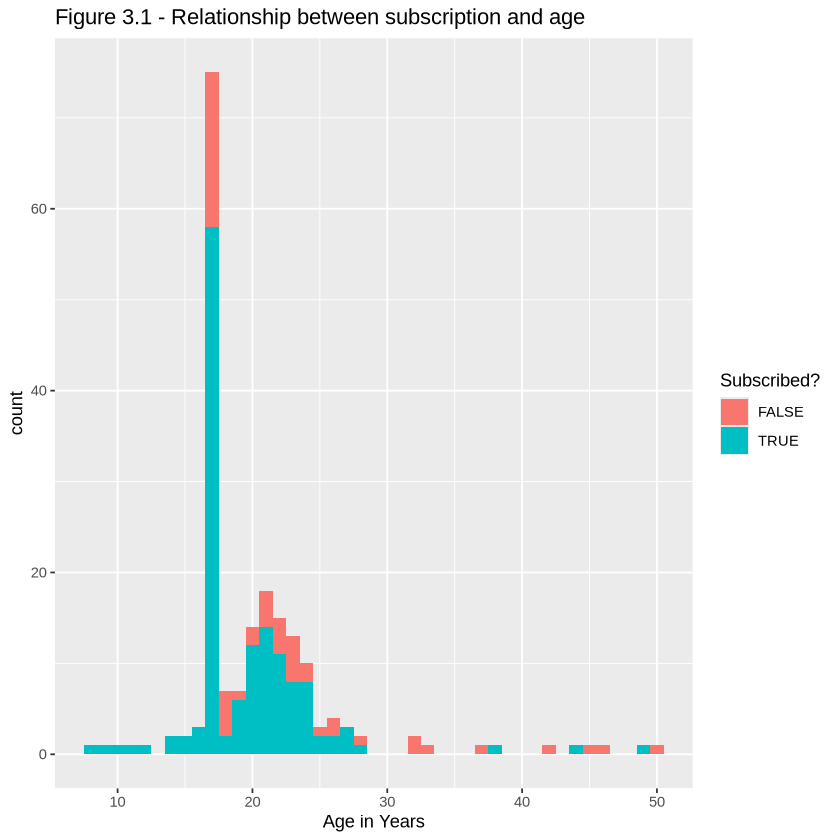

In [36]:
age_histogram <- ggplot(player_data, aes(x = age)) +
                geom_histogram(binwidth = 1, aes(fill = subscribe)) +
                labs(x = "Age in Years", fill = "Subscribed?") +
                ggtitle("Figure 3.1 - Relationship between subscription and age")
age_histogram

In this histogram, it can be observed that the vast majority of the observations come from subjects within the age range of 15 to 25. Due to this limitation of the data set, it was decided that the prediction should also be made for ages 15 - 25 specifically, so that the model does not make wrong and general assumptions about other age ranges. 

Thus, analysis using other variables should also be focused on this age range. I created a new dataframe named `player_data_filtered` to simplify further analysis. 

In [35]:
player_data_filtered <- player_data |>
                        filter(age > 15, age < 25)
player_data_filtered

experience,subscribe,played_hours,gender,age
<fct>,<lgl>,<dbl>,<chr>,<dbl>
Veteran,TRUE,3.8,Male,17
Veteran,FALSE,0.0,Male,17
Amateur,TRUE,0.7,Female,21
⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,0.3,Male,22
Amateur,FALSE,0.0,Prefer not to say,17
Amateur,FALSE,2.3,Male,17


fig. 3.2 - Player data with only players with age between 15 and 25

## Time played and subscription

To discover the relationship between gaming time and subscription, the average play time was calculated for each of the two states of subscription. The numbers are then compared in a table. 

In [19]:
avg_time_sub <- player_data_filtered |>
                group_by(subscribe) |>
                summarize(avg_time_played_hrs = mean(played_hours, na.rm = TRUE))
avg_time_sub

subscribe,avg_time_played_hrs
<lgl>,<dbl>
FALSE,0.53750
TRUE,8.42623


Fig. 4 - subscription state and the average gaming time in hours

It appears that players subscribed to gaming-related newsletters have much higher average play times. This large difference suggests that `played_hours` will serve as a great predictor for `subscribe`.

## Experience and Subscription

First, chart is created to contrast the number of entries gathered for each value of `experience`.

In [20]:
exp_count <- player_data_filtered |>
    group_by(experience) |>
    summarize(count = n())
exp_count

experience,count
<fct>,<int>
Beginner,28
Amateur,54
Regular,28
Pro,9
Veteran,43


Fig. 5.1 - Number of players in each experience level

Through the table, one may see that the amount observations vary drastically across the 5 `experience` levels. Again, this will affect the final prediction model. 

A stacked bar graph is generated to visualize the percentages of subscription across the skill levels. 

In [21]:
experience_sub <- player_data_filtered |>
                group_by(experience, subscribe) |>
                summarize(count = n()) |>
                mutate(total_num = nrow(player_data)) |>
                mutate(percentage = count / total_num) |>
                select(experience, subscribe, percentage)

`summarise()` has grouped output by 'experience'. You can override using the
`.groups` argument.


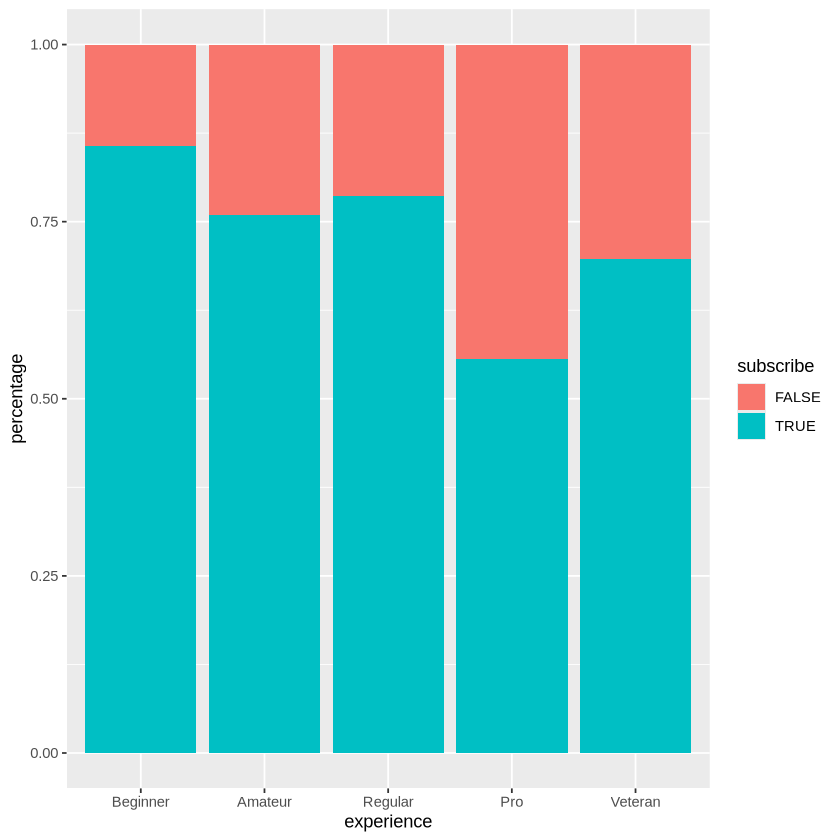

In [22]:
experience_sub_graph <- ggplot(experience_sub, aes(x = experience, y = percentage)) +
                        geom_bar(stat = "identity", position = "fill", aes(fill = subscribe))
experience_sub_graph

Fig. 5.2 - Proportion of subscribers for various experience levels

Since players of different experience levels have different proportions for the `subscribed` variable, it suggests that `experience` may be a useful predictor. 

## Gender and Subscription

Observations for each gender is tallied. 

In [23]:
gender_count <- player_data_filtered |>
        group_by(gender) |>
        summarize(count = n())
gender_count

gender,count
<chr>,<int>
Agender,1
Female,30
Male,105
Non-binary,14
Prefer not to say,8
Two-Spirited,4


Fig. 6.1 - Number of participants for each specified gender

Again, it must be acknowledged that the amount of information are not equivalent for the genders.

In [24]:
gender_sub <- player_data_filtered |>
        group_by(gender, subscribe) |>
        summarize(count = n()) |>
        arrange(desc(count)) |>
        mutate(total_players = nrow(player_data)) |>
        mutate(percentage = count / total_players) |>
        select(gender, subscribe, percentage)

`summarise()` has grouped output by 'gender'. You can override using the
`.groups` argument.


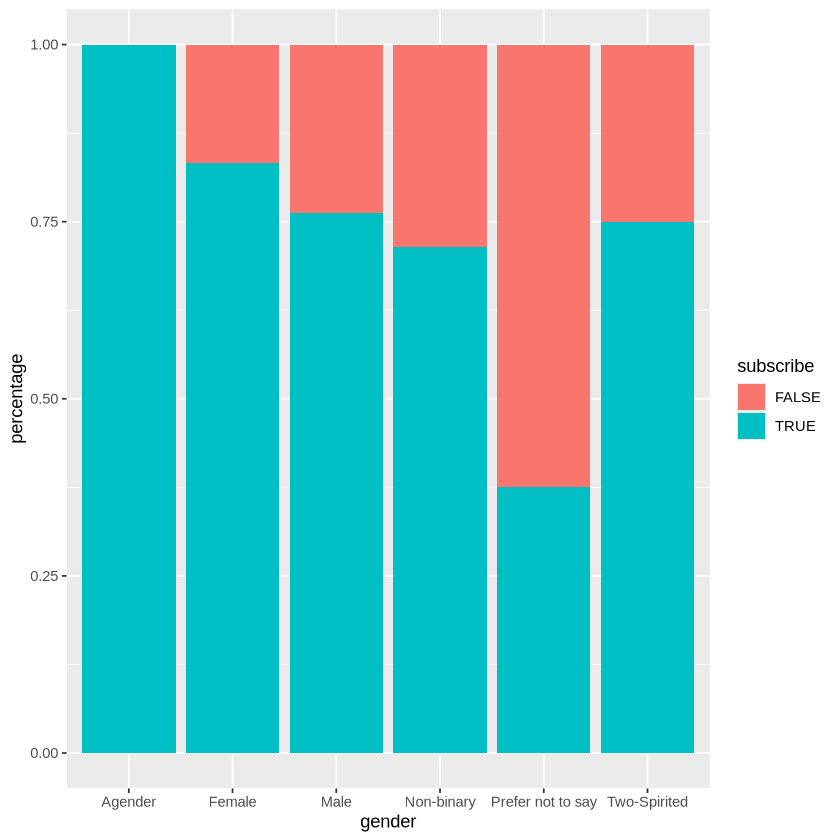

In [37]:
gender_sub_plot <- ggplot(gender_sub, aes(x = gender, y = percentage)) + 
    geom_bar(stat = "identity", position = "fill", aes(fill = subscribe))
gender_sub_plot

Fig. 6.2 - Proportion of subscribers for each specified gender

## Creating the KNN Classifer

First, data is processed in preparation for the binary classifier. Specifically:
- `subscribe` variable is turned into the variable type `fct`;
- `age` is omitted as it was deemed unsuitable as a predictor, due to reasons explained above. 

In [26]:
player_processed <- player_data_filtered |>
                    select(-age) |>
                    mutate(subscribe = as_factor(subscribe)) |>
                    mutate(gender = as_factor(gender))

The data set is then split 70 - 30 into `training` and `testing` objects.

In [27]:
set.seed(1000)
player_split <- initial_split(player_processed, prop = 0.70, strata = subscribe)
player_training <- training(player_split)
player_testing <- testing(player_split)

In the following code, cross-validation with 5 folds is used to determine the optimal K value. 

In [28]:
set.seed(2000)
sub_recipe <- recipe(subscribe ~ played_hours + experience + gender, data = player_training) |>
            step_scale(played_hours) |>
            step_center(played_hours)
sub_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")
sub_vfold <- vfold_cv(player_training, v = 5, strata = subscribe)
vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

sub_fit <- workflow() |>
        add_recipe(sub_recipe) |>
        add_model(sub_spec) |>
        tune_grid(resamples = sub_vfold, grid = vals) |>
        collect_metrics() |>
        filter(.metric == "accuracy") |>
        filter(mean == max(mean)) |>
        mutate(accuracy = mean) |>
        mutate(k_value = neighbors) |>
        select(k_value, accuracy)
sub_fit

k_value,accuracy
<dbl>,<dbl>
9,0.7351779
10,0.7351779


Table 7.1 - Top predicted accuracy and associated K values

The selected K-value is used to train the training data set to generate the predictive model, as shown below. 

In [29]:
set.seed(3000)
tuned_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
            set_engine("kknn") |>
            set_mode("classification")
tuned_fit <- workflow() |>
            add_recipe(sub_recipe) |>
            add_model(tuned_spec) |>
            fit(player_training)

In [30]:
set.seed(4000)
player_predictions <- predict(tuned_fit, player_testing) |>
                    bind_cols(player_testing)

In [31]:
player_metrics <- player_predictions |>
                metrics(truth = subscribe, estimate = .pred_class) |>
                filter(.metric == "accuracy")
player_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.755102


Table 7.2 - Measured accuracy of predictive model on testing data set

In [44]:
player_conf_mat <- player_predictions |>
                    conf_mat(truth = subscribe, estimate = .pred_class)
player_conf_mat

          Truth
Prediction FALSE TRUE
     FALSE     2    2
     TRUE     10   35

Table 7.3 - Confusion matrix for the predictive model

In the following analysis of recall and precision, `TRUE` is picked as the positive value. 

$Recall = 35 / 37 = 0.95$

$Precision = 35 / 45 = 0.78$

I chose to use the KNN classification method because it is simple to implement and reproduce, and it is able to classify without assumptions on the shape of the relationships, which is difficult to tell is this analysis. The potential limitations to KNN classification is that it can be slow when the training data gets too large. If this model is to be implemented on an expanded dataset with more player data, the computation time should be taken into consideration. 

I select this KNN classification, specifically with K = 9, since I through using the cross-validation on the training dataset, I observed that it is the K value that has the highest accuracy. 

# Discussion

In summary, a predictive model classifying whether or not players subscribed to gaming-related newspapers is created based on gaming time, experience, and gender of the player. Even though the accuracy and precision of the model is not very high (at 76% and 78% respectively), it has a very high recall value of 95%. This is good since it means that the majority of the potential newspaper clients can be identified. This is what is expected to be found. 

The finding that subscription can be predicted by the variables stated above can allow gaming-content creators to target their content accordingly. Future questions that can be prosed include: what are some other factors that affect subscription? For example, what is the relationship between geographic location and the subscription rate in Canada?